In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from models import SBN
from utils import summary

In [4]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', 'gray'] 

In [5]:
tree_dict_total, tree_names_total, tree_wts_total = summary('DS1', '../data/raw_data_DS1-4/')

In [6]:
emp_tree_freq = {tree_dict_total[tree_name]:tree_wts_total[i] for i, tree_name in enumerate(tree_names_total)}

In [7]:
taxa = tree_dict_total[tree_names_total[0]].get_leaf_names()

In [11]:
K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
n_rep =10
kl_div_mat_freq = np.empty((n_rep, 7))

for rep in range(n_rep):
    for k, n_trees in enumerate(K_v):
        print('rep {}, sample size: {}'.format(rep+1, n_trees))
        
        tree_id = np.load('../data/DS1/rep_{}/{}-samp-tree-dict.npy'.format(rep+1, n_trees), allow_pickle=True).item()
        tree_count_dict = np.load('../data/DS1/rep_{}/{}-samp-tree-count-dict.npy'.format(rep+1, n_trees), allow_pickle=True).item()
        
        model = SBN(taxa, emp_tree_freq)
        model.bn_train_count(tree_count_dict, tree_id)
        
        kl_div = model.kl_div(method='freq')
        kl_div_mat_freq[rep, k] = kl_div['freq']
    
        print('rep {}, kl_div {}'.format(rep+1, kl_div_mat_freq[rep, k]))

rep 1, sample size: 10000
rep 1, kl_div 0.25119110258559507
rep 1, sample size: 20000
rep 1, kl_div 0.2953129176682343
rep 1, sample size: 40000
rep 1, kl_div 0.12782258942558222
rep 1, sample size: 80000
rep 1, kl_div 0.08294032188163936
rep 1, sample size: 160000
rep 1, kl_div 0.04226445823778002
rep 1, sample size: 320000
rep 1, kl_div 0.02121016988988922
rep 1, sample size: 640000
rep 1, kl_div 0.01410612605160022
rep 2, sample size: 10000
rep 2, kl_div 0.27129837459982875
rep 2, sample size: 20000
rep 2, kl_div 0.21966726627297994
rep 2, sample size: 40000
rep 2, kl_div 0.1031441756357192
rep 2, sample size: 80000
rep 2, kl_div 0.0750142275801906
rep 2, sample size: 160000
rep 2, kl_div 0.052344514758200233
rep 2, sample size: 320000
rep 2, kl_div 0.02893667051248716
rep 2, sample size: 640000
rep 2, kl_div 0.01456884435445538
rep 3, sample size: 10000
rep 3, kl_div 0.2798425296909244
rep 3, sample size: 20000
rep 3, kl_div 0.17561924080569158
rep 3, sample size: 40000
rep 3, kl_d

In [12]:
if not os.path.exists('../results/DS1/method'):
    os.makedirs('../results/DS1/method')
if not os.path.exists('../results/DS1/n_tree'):
    os.makedirs('../results/DS1/n-tree')

In [20]:
# K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
K_v = [10000, 20000]
methods = ['ccd', 'sbn-sa', 'sbn-em', 'sbn-em-alpha']
n_rep = 2 # 10
reg_lam = 100.0
kl_div_mat = np.empty((n_rep, 7, 4))

for rep in range(n_rep):    
    output_methods = '../results/DS1/method/rep' + '{:02d}'.format(rep+1)
    output_n_unique_tree = '../results/DS1/n-tree/rep' +'{:02d}'.format(rep+1)

    kl_div_methods = open(output_methods, 'w')
    n_unique_tree = open(output_n_unique_tree, 'w')
    
    kl_div_methods.write('K'.ljust(8) + '\t'.join([str(method).ljust(13) for method in methods]) +'\n')
    n_unique_tree.write('\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    
    kl_div_methods.flush()
    n_unique_tree.flush()    
    
    for k, n_trees in enumerate(K_v):
        kl_div_methods.write('{:06d}'.format(n_trees))
        print('rep {}, dataset {}, sample size {}, loading data'.format(rep, 'DS1', n_trees))
        tree_id = np.load('../data/DS1/rep_{}/{}-samp-tree-dict.npy'.format(rep+1, n_trees),allow_pickle=True).item()
        tree_count_dict = np.load('../data/DS1/rep_{}/{}-samp-tree-count-dict.npy'.format(rep+1, n_trees), allow_pickle=True).item()
        
        model = SBN(taxa, emp_tree_freq)
        model.bn_train_count(tree_count_dict, tree_id)

        kl_div = model.kl_div()
        kl_div_mat[rep, k, 0], kl_div_mat[rep, k, 1] = kl_div['ccd'], kl_div['bn']
        
        print('SBN-EM training: rep {}, dataset {}, sample size {}'.format(rep, 'DS1', n_trees))
        logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=1000, abstol=1e-05, monitor=True, MAP=False)
        kl_div_mat[rep, k, 2] = model.kl_div(method='bn')['bn']   
        
        model = SBN(taxa, emp_tree_freq, alpha=reg_lam/n_trees)
        print('SBN-EM-ALPHA training: rep {}, dataset {}, sample size {}'.format(rep, 'DS1', n_trees))
        logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=1000, abstol=1e-05, monitor=True, MAP=True)
        kl_div_mat[rep, k, 3] = model.kl_div(method='bn', MAP=True)['bn']
        
        kl_div_methods.write(''.join(['\t{:.11f}'.format(kl_div_mat[rep,k,l]) for l in range(4)]) + '\n')
        n_unique_tree.write(str(len(tree_count_dict)).ljust(6)+'\t')

        kl_div_methods.flush()
        n_unique_tree.flush()  

    n_unique_tree.write('\n')
    
    kl_div_methods.close()
    n_unique_tree.close()            

rep 0, dataset DS1, sample size 10000, loading data
SBN-EM training: rep 0, dataset DS1, sample size 10000
Iter: 1: current per tree log-likelihood -2.905582
Iter: 2: current per tree log-likelihood -2.901429
Iter: 3: current per tree log-likelihood -2.900449
Iter: 4: current per tree log-likelihood -2.900222
Iter: 5: current per tree log-likelihood -2.900120
Iter: 6: current per tree log-likelihood -2.900062
Iter: 7: current per tree log-likelihood -2.900025
Iter: 8: current per tree log-likelihood -2.899998
Iter: 9: current per tree log-likelihood -2.899978
Iter: 10: current per tree log-likelihood -2.899959
Iter: 11: current per tree log-likelihood -2.899940
Iter: 12: current per tree log-likelihood -2.899920
Iter: 13: current per tree log-likelihood -2.899900
Iter: 14: current per tree log-likelihood -2.899876
Iter: 15: current per tree log-likelihood -2.899849
Iter: 16: current per tree log-likelihood -2.899813
Iter: 17: current per tree log-likelihood -2.899764
Iter: 18: current 

In [21]:
kl_div_mat_merg = np.concatenate((kl_div_mat, kl_div_mat_freq.reshape(n_rep, 7, -1)), axis=2)

In [22]:
model = SBN(taxa, emp_tree_freq)

In [23]:
logp = model.bn_em_prob(tree_dict_total, tree_names_total, tree_wts_total, maxiter=100, abstol=1e-05, monitor=True, MAP=False)

Iter 1: current per tree log-likelihood -2.954282
Iter 2: current per tree log-likelihood -2.950041
Iter 3: current per tree log-likelihood -2.949119
Iter 4: current per tree log-likelihood -2.948953
Iter 5: current per tree log-likelihood -2.948856
Iter 6: current per tree log-likelihood -2.948778
Iter 7: current per tree log-likelihood -2.948709
Iter 8: current per tree log-likelihood -2.948643
Iter 9: current per tree log-likelihood -2.948577
Iter 10: current per tree log-likelihood -2.948517
Iter 11: current per tree log-likelihood -2.948470
Iter 12: current per tree log-likelihood -2.948433
Iter 13: current per tree log-likelihood -2.948401
Iter 14: current per tree log-likelihood -2.948369
Iter 15: current per tree log-likelihood -2.948329
Iter 16: current per tree log-likelihood -2.948275
Iter 17: current per tree log-likelihood -2.948194
Iter 18: current per tree log-likelihood -2.948071
Iter 19: current per tree log-likelihood -2.947880
Iter 20: current per tree log-likelihood

In [24]:
bn_em_est_prob = [model.bn_estimate(tree_dict_total[tree_name]) for tree_name in tree_names_total]

In [25]:
sum(bn_em_est_prob), max(bn_em_est_prob)

(0.9994882515181008, 0.2749923441228077)

In [27]:
kl_div_mean = np.mean(kl_div_mat_merg, axis=0)
kl_div_std = np.std(kl_div_mat_merg, axis=0)

In [47]:
# K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
K_v = [10000, 20000]
labels={0:'ccd',1:'sbn-sa',2:'sbn-em',3:'sbn-em-'+r'$\alpha$',4:'srf'}
fmts={0:'-o',1:'-s',2:'-d',3:'-^',4:'--P'}
marksz={0:5,1:5,2:6,3:6,4:6}

In [48]:
kl_div_mean[:2,0]

array([0.67328461, 0.83246593])

In [49]:
kl_div_std

array([[2.69128577e-002, 1.11875375e-002, 9.18503999e-003,
        1.84709674e-003, 3.93055462e-002, 4.79860474e-002,
        2.75869336e-003, 6.28517403e-003, 5.17588589e-003],
       [8.51586265e-002, 4.24592320e-002, 4.33213040e-002,
        4.37002531e-002, 2.62612456e-003, 4.36211897e-004,
        2.25192851e-002, 3.21978630e-002, 1.01094198e-002],
       [            inf,             inf, 2.68611325e+151,
                    inf, 1.23481669e-002, 4.42753227e-003,
        4.05148201e-003, 2.10602326e-003, 1.85931390e-002],
       [            inf, 9.87268727e-154,             inf,
        5.28888391e-154, 1.38801413e-002, 1.85702044e-003,
        1.43513416e-003, 8.40666744e-004, 2.70402761e-004],
       [9.84790642e-154,             inf,             inf,
        1.53658506e-027, 3.02556008e-004, 4.91747495e-002,
        3.94472995e-003, 3.46510536e-003, 9.06080076e-004],
       [            inf,             inf,             inf,
        7.03265517e+141, 1.35204631e-003, 5.8287104

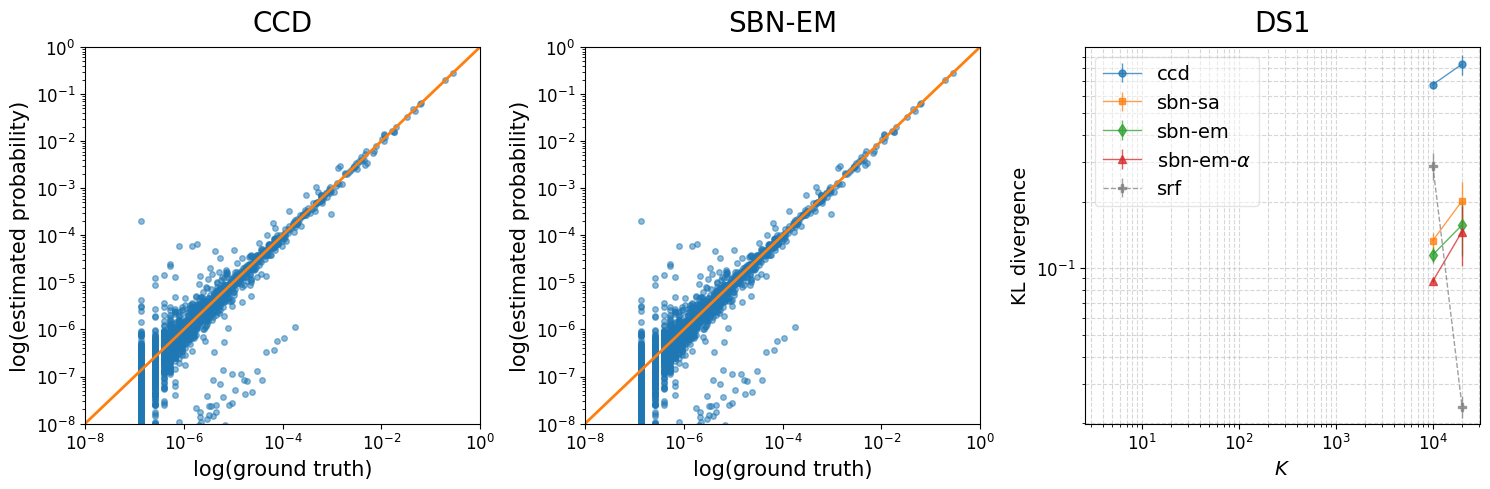

In [50]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(tree_wts_total, bn_em_est_prob, 'o', markersize=4, alpha=0.5)
ax1.set_xlim([1e-8,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax1.set_title('CCD', y=1.02, fontsize=20)
ax1.set_xlabel('log(ground truth)',fontsize=15)
ax1.set_ylabel('log(estimated probability)',fontsize=15)
ax1.tick_params(labelsize=12)

ax2.plot(tree_wts_total, bn_em_est_prob, 'o', markersize=4, alpha=0.5)
ax2.set_xlim([1e-8,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax2.set_title('SBN-EM', y=1.02, fontsize=20)
ax2.set_xlabel('log(ground truth)',fontsize=15)
ax2.set_ylabel('log(estimated probability)',fontsize=15)
ax2.tick_params(labelsize=12)


ax3.set_xscale('log')
ax3.set_yscale('log')
for i in [0,1,2,3,4]:
    ax3.errorbar(K_v, kl_div_mean[:2,i], yerr=kl_div_std[:2,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)

leg = ax3.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax3.grid(which='both', linestyle='--', alpha=0.5)
ax3.tick_params(labelsize=12)
ax3.set_xlabel(r'$K$', fontsize=14)
ax3.set_ylabel('KL divergence', fontsize=14)
ax3.set_title('DS1', y=1.02, fontsize=20)

plt.tight_layout()

plt.show()